# Каршеринг. Прогнозирование вероятности ДТП

## Введение
**Цель работы:** обучить и подобрать модель, способную предсказывать вероятность ДТП по историческим данным.

**Задачи работы:**
1. Провести анализ данных.
2. Сформировать как минимум 3 модели и обучить их.
3. Выбрать модель с наилучшими параметрами.
4. Определить наиболее важные факторы.
5. Предложить пути предотвращения ДТП.

**План работы:**
1. Получить данные из базы с помощью SQL-запросов.
2. Провести анализ данных.
3. Подготовить задания для коллег по изучению данных.
4. Сформировать и обучить как минимум три модели.
5. Выбрать наилучшую модель.
6. Проанализировать работу модели.
7. Сформировать выводы.

**Описание работы:**
нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.  
Идея решения задачи от заказчика:
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Краткое описание таблиц
- collisions — общая информация о ДТП. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- parties — информация об участниках ДТП.
- vehicles — информация о пострадавших машинах.

## Подключение к базе и загрузка данных

### Установка и загрузка библиотек

In [ ]:
!pip install phik -q
!pip install sqlalchemy -q
!pip install scikit-learn==1.5.2 -q
!pip install lightgbm -q
!pip install shap -q

In [ ]:
# Стандартные библиотеки
import pandas as pd
import numpy as np

# Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Для расчета корреляции
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px


# Для работы с SQL
from sqlalchemy import create_engine

# Библиотеки для работы с моделями
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import svm

# Оценка качества и интерпретация модели
from sklearn.metrics import roc_auc_score, confusion_matrix
import shap

# Импорты для обработки предупреждений
import warnings
warnings.filterwarnings("ignore")

### Подключение к базе SQL

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

### Знакомство с данными

Подготовим ознакомительные запросы:

In [ ]:
query_case_ids = '''
SELECT *
FROM case_ids
LIMIT 5
'''

In [ ]:
query_collisions = '''
SELECT *
FROM collisions
LIMIT 5
'''

In [ ]:
query_vehicles = '''
SELECT *
FROM vehicles
LIMIT 5
'''

In [ ]:
query_parties = '''
SELECT *
FROM parties
LIMIT 5
'''

Загрузим ознакомительные фрагменты:

In [ ]:
df_case_ids = pd.read_sql_query(query_case_ids, con = engine)

In [ ]:
df_case_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  5 non-null      object
 1   db_year  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


Количество столбцов и их название совпадает с условием задачи.

In [ ]:
df_case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [ ]:
df_collisions = pd.read_sql_query(query_collisions, con = engine)

In [ ]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      5 non-null      object 
 1   county_city_location         5 non-null      object 
 2   county_location              5 non-null      object 
 3   distance                     5 non-null      float64
 4   direction                    1 non-null      object 
 5   intersection                 5 non-null      int64  
 6   weather_1                    5 non-null      object 
 7   location_type                1 non-null      object 
 8   collision_damage             5 non-null      object 
 9   party_count                  5 non-null      int64  
 10  primary_collision_factor     5 non-null      object 
 11  pcf_violation_category       5 non-null      object 
 12  type_of_collision            5 non-null      object 
 13  motor_vehicle_involved_w

Количество столбцов и их название совпадает с условием задачи.

In [ ]:
df_collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [ ]:
df_vehicles = pd.read_sql_query(query_vehicles, con = engine)

In [ ]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    5 non-null      int64 
 1   case_id               5 non-null      object
 2   party_number          5 non-null      int64 
 3   vehicle_type          5 non-null      object
 4   vehicle_transmission  5 non-null      object
 5   vehicle_age           5 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 368.0+ bytes


In [ ]:
df_vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Количество столбцов и их название совпадает с условием.

In [ ]:
df_parties = pd.read_sql_query(query_parties, con = engine)

In [ ]:
df_parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [ ]:
df_parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5 non-null      int64  
 1   case_id              5 non-null      object 
 2   party_number         5 non-null      int64  
 3   party_type           5 non-null      object 
 4   at_fault             5 non-null      int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       5 non-null      object 
 7   party_drug_physical  1 non-null      object 
 8   cellphone_in_use     5 non-null      int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 488.0+ bytes


Во всех таблицах количество столбцов и их названия совпадает с условием. Общий ключ для связи таблиц имеется. Это case_id.

**Итог:** данный осмотрены.

## Статистический анализ факторов ДТП

### Количество аварий по месяцам

Посмотрим, за какие года есть информация:

In [ ]:
query_year = '''
SELECT DISTINCT(EXTRACT(YEAR FROM CAST(collision_date AS date))) AS year
FROM collisions
'''

In [ ]:
pd.read_sql_query(query_year, con = engine)

,year
0,2020.0
1,2010.0
2,2009.0
3,2011.0
4,2012.0
5,2013.0


Теперь посмотрим, в каких годах есть информация за все месяцы:

In [ ]:
query_2009_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2009
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

query_2010_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2010
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

query_2011_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2011
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

query_2012_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2012
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

query_2013_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2013
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

query_2020_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2020
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

In [ ]:
list_query = [query_2009_case, query_2010_case, query_2011_case, query_2012_case, query_2013_case, query_2020_case]

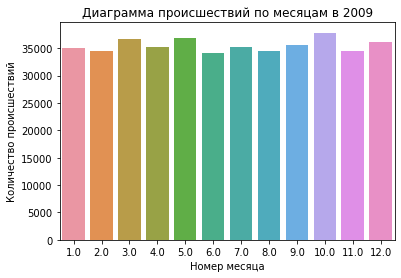

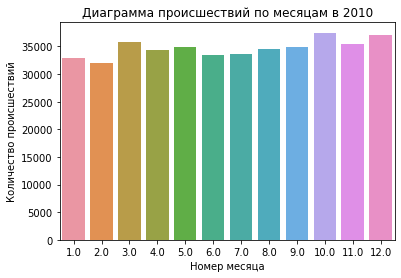

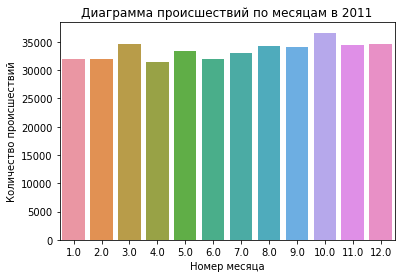

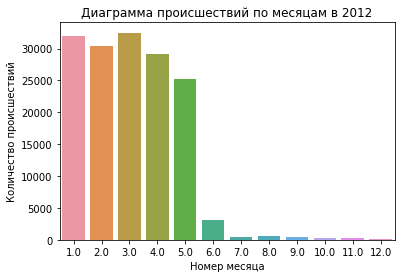

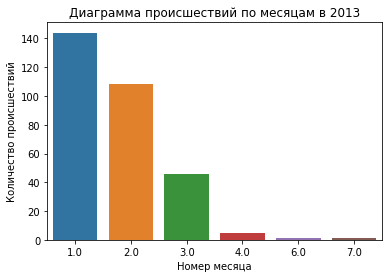

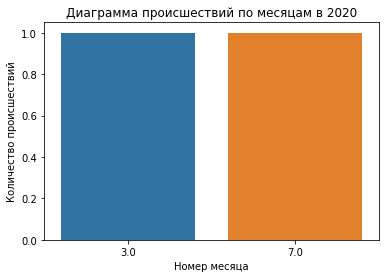

In [ ]:
for query, year in zip(list_query, [2009, 2010, 2011, 2012, 2013, 2020]):
    df_year_case = pd.read_sql_query(query, con = engine)
    ax = sns.barplot(data=df_year_case, x='month', y='count_case')
    ax.set(xlabel='Номер месяца', ylabel='Количество происшествий', title=f'Диаграмма происшествий по месяцам в {year}')
    plt.show()


Только в трёх годах есть информация за все месяцы: 2009, 2010, 2011. На основании них и построим общую диаграмму.

Сформируем запрос

In [ ]:
query_count_case = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
       COUNT(case_id) AS count_case
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2009
OR EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2010
OR EXTRACT(YEAR FROM CAST(collision_date AS date)) = 2011
GROUP BY EXTRACT(MONTH FROM CAST(collision_date AS date))
'''

Загрузим данные и сохраним в переменную

In [ ]:
df_count_case = pd.read_sql_query(query_count_case, con = engine)

Построим график

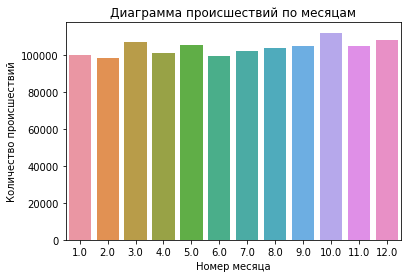

In [ ]:
ax = sns.barplot(data=df_count_case, x='month', y='count_case')
ax.set(xlabel='Номер месяца', ylabel='Количество происшествий', title=f'Диаграмма происшествий по месяцам')
plt.show()

Как видно, наибольшее количество происшествий происходит в марте и октябре, наименьшее - в феврале и июне. В принципе, это объяснимо, так как в марте и октябре погода неустойчива и может возникать гололед, в июне люди в отпуске и машин на дороге мало, а февраль месяц короткий.

### Подготовка заданий для коллег

Для ознакомления с данными предлагаются следующие задачи:
1. Выяснить, с каким объектом чаще всего случаются ДТП в туман. Построить график об авариях в туман, в которых отразить количество каждого типа участника происшествия.
2. Оценить, насколько влияет наличие возможности говорить по громкой связи в автомобиле на тяжесть ДТП.
3. Оценить, при каком состоянии дорог больше всего аварий.
4. Оценить, на каком типе дорог чаще всего случаются ДТП с участием пьяных водителей.
5. Оценить, какой тип автомобилей чаще всего попадает в аварии на перекрестках.
6. С автомобилями с каким типом коробки передач чаще всего сталкиваются велосепедисты ночью с уровнем поверждения выше царапины?

В качестве примеры решим задачи 3 и 6.  
**Задача 3:** Оценить, насколько влияет наличие возможности говорить по громкой связи в автомобиле на тяжесть ДТП.

Для решения задачи создадим три запроса. Один основной и два подзапроса.

In [ ]:
query_cellphone_case = '''
WITH without_cellphone AS
                          (SELECT c.collision_damage AS collision_damage,
                                  COUNT (c.case_id) AS cases_without_phone
                           FROM collisions AS c
                           JOIN parties AS p ON c.case_id = p.case_id
                           WHERE p.cellphone_in_use = 0
                           GROUP BY c.collision_damage
                           ),
     with_cellphone AS    (
                           SELECT c.collision_damage AS collision_damage,
                                  COUNT (c.case_id) AS cases_with_phone
                           FROM collisions AS c
                           JOIN parties AS p ON c.case_id = p.case_id
                           WHERE p.cellphone_in_use = 1
                           GROUP BY c.collision_damage)
SELECT woc.collision_damage,
       woc.cases_without_phone,
       wc.cases_with_phone
FROM without_cellphone AS woc
JOIN with_cellphone AS wc ON woc.collision_damage = wc.collision_damage
'''

Загрузим данные в переменную:

In [ ]:
df_cellphone_case = pd.read_sql_query(query_cellphone_case, con = engine)

Построим графики:

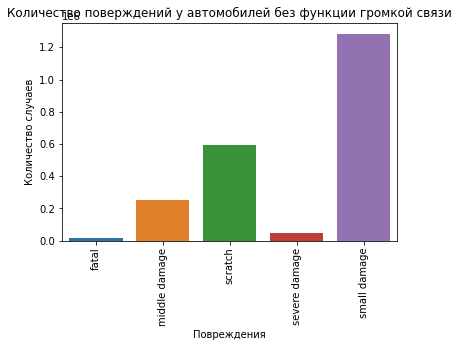

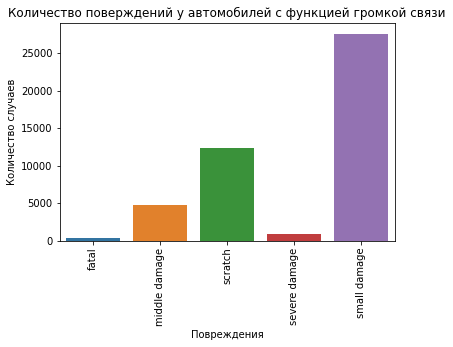

In [ ]:
ax = sns.barplot(data=df_cellphone_case, x='collision_damage', y='cases_without_phone')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Повреждения', ylabel='Количество случаев', title=f'Количество поверждений у автомобилей без функции громкой связи')
plt.show()
ax = sns.barplot(data=df_cellphone_case, x='collision_damage', y='cases_with_phone')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Повреждения', ylabel='Количество случаев', title=f'Количество поверждений у автомобилей с функцией громкой связи')
plt.show()

Распределение одинаковое в обоих случаях одинаковое. Значит не влияет наличие возможности разговора по громкой связи на тяжесть ДТП.

**Решим задачу 6:** С автомобилями с каким типом коробки передач чаще всего сталкиваются велосепедисты ночью с уровнем поверждения выше царапины?

Сформируем первый запрос для оценки, сколько машин с тем или иными типом коробки передач

In [ ]:
query_transmission_case = '''
SELECT v.vehicle_transmission AS type_transmission,
       COUNT(c.case_id) AS count_case
FROM vehicles AS v
JOIN collisions AS c ON v.case_id = c.case_id
GROUP BY v.vehicle_transmission
'''

In [ ]:
df_transmission_case = pd.read_sql_query(query_transmission_case, con = engine)

Построим график

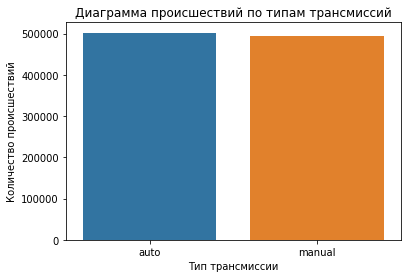

In [ ]:
ax = sns.barplot(data=df_transmission_case, x='type_transmission', y='count_case')
ax.set(xlabel='Тип трансмиссии', ylabel='Количество происшествий', title=f'Диаграмма происшествий по типам трансмиссий')
plt.show()

Количество происшествий с автоматической коробкой и с ручной примерно одинаковое.

Теперь сформируем основной запрос

In [ ]:
query_bicycle_case = '''
SELECT v.vehicle_transmission AS type_transmission,
       COUNT(c.case_id) AS count_case
FROM vehicles AS v
JOIN collisions AS c ON v.case_id = c.case_id
WHERE (c.lighting = 'dark with no street lights'
OR c.lighting = 'dark with street lights not functioning')
AND c.motor_vehicle_involved_with = 'bicycle'
AND c.collision_damage != 'scratch'
GROUP BY v.vehicle_transmission
'''

Загрузим данные и сохраним в переменную

In [ ]:
df_bicycle_case = pd.read_sql_query(query_bicycle_case, con = engine)

Построим график

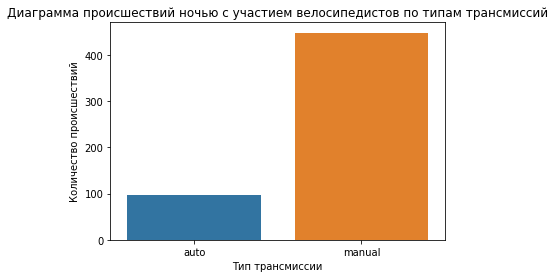

In [ ]:
ax = sns.barplot(data=df_bicycle_case, x='type_transmission', y='count_case')
ax.set(xlabel='Тип трансмиссии', ylabel='Количество происшествий', title=f'Диаграмма происшествий ночью с участием велосипедистов по типам трансмиссий')
plt.show()

В темное время суток чаще всего попадают в аварии с участием велосипедистов машины с ручной коробкой передач.

**Итог:** задания для коллег сформированы.

## Создание модели для оценки водительского риска

### Выгрузка из базы выборки

В соответствии с предположением заказчика, тип виновника установим как машину. Будем рассматривать повреждения больше, чем царапина и возьмем данные за 2012 год.
Сформируем SQL-запрос:

In [ ]:
query_car_fault = '''
SELECT *,
       EXTRACT(MONTH FROM CAST(c.collision_date AS date)) AS month,
       EXTRACT(DOW FROM CAST(c.collision_date AS date)) AS weekday
FROM parties AS p
RIGHT JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
RIGHT JOIN collisions AS c ON p.case_id = c.case_id
WHERE p.party_type = 'car'
AND EXTRACT(YEAR FROM CAST(c.collision_date AS date)) = 2012
AND c.collision_damage != 'scratch'
'''

Сохраним таблицу в переменную и проверим результат:

In [ ]:
df_car_fault = pd.read_sql_query(query_car_fault, con = engine)

In [ ]:
df_car_fault.head(3)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,month,weekday
0,2395824,5449062,2,car,0,54.0,had not been drinking,None,0.0,1320506,...,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,1.0,0.0
1,2659554,5600850,2,car,0,NaN,impairment unknown,G,0.0,1465119,...,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-04-19,12:44:00,4.0,4.0
2,2659617,5600893,1,car,1,38.0,"had been drinking, under influence",None,0.0,1465137,...,hit object,other object,dry,normal,dark with no street lights,none,2012-04-21,00:50:00,4.0,6.0


In [ ]:
df_car_fault.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   party_type                   56248 non-null  object 
 4   at_fault                     56248 non-null  int64  
 5   insurance_premium            55701 non-null  float64
 6   party_sobriety               55376 non-null  object 
 7   party_drug_physical          2857 non-null   object 
 8   cellphone_in_use             51777 non-null  float64
 9   id                           56248 non-null  int64  
 10  case_id                      56248 non-null  object 
 11  party_number                 56248 non-null  int64  
 12  vehicle_type                 56248 non-null  object 
 13  vehicle_transmis

Таблица подготовлена.

In [ ]:
df_car_fault.columns

Index(['id', 'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'id', 'case_id', 'party_number', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'case_id',
       'county_city_location', 'county_location', 'distance', 'direction',
       'intersection', 'weather_1', 'location_type', 'collision_damage',
       'party_count', 'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'collision_date',
       'collision_time', 'month', 'weekday'],
      dtype='object')

### Корреляционный анализ

Для выбора признаков для модели посмотрим матрицу корреляции методом phik. Так как признаков много, разобьем матрицу на две части.

Выберем признаки, которые мы знаем на момент начала движения:

In [ ]:
known_columns=[
'at_fault',  # целевой признак
'insurance_premium',  # знаем до начала движения
'party_sobriety',  # можем узнать до начала движения
'party_drug_physical', # можем узнать до начала движения
'cellphone_in_use',  # знаем до начала движения
'vehicle_type', # знаем до начала движения
'vehicle_transmission', # знаем до начала движения
'vehicle_age', # знаем до начала движения
'county_location', # знаем до начала движения
'distance', # можем узнать до начала движения, построив маршрут
'direction', # можем узнать до начала движения, построив маршрут
'intersection', # можем узнать до начала движения, построив маршрут
'weather_1', # знаем до начала движения
'location_type', # можем узнать до начала движения, построив маршрут
'road_surface',  # можем узнать до начала движения, построив маршрут
'road_condition_1', # можем узнать до начала движения, построив маршрут
'lighting', # можем узнать до начала движения, построив маршрут
'control_device', # знаем до начала движения
'month', # знаем до начала движения
'weekday' # знаем до начала движения
]

Первая матрица корреляции:

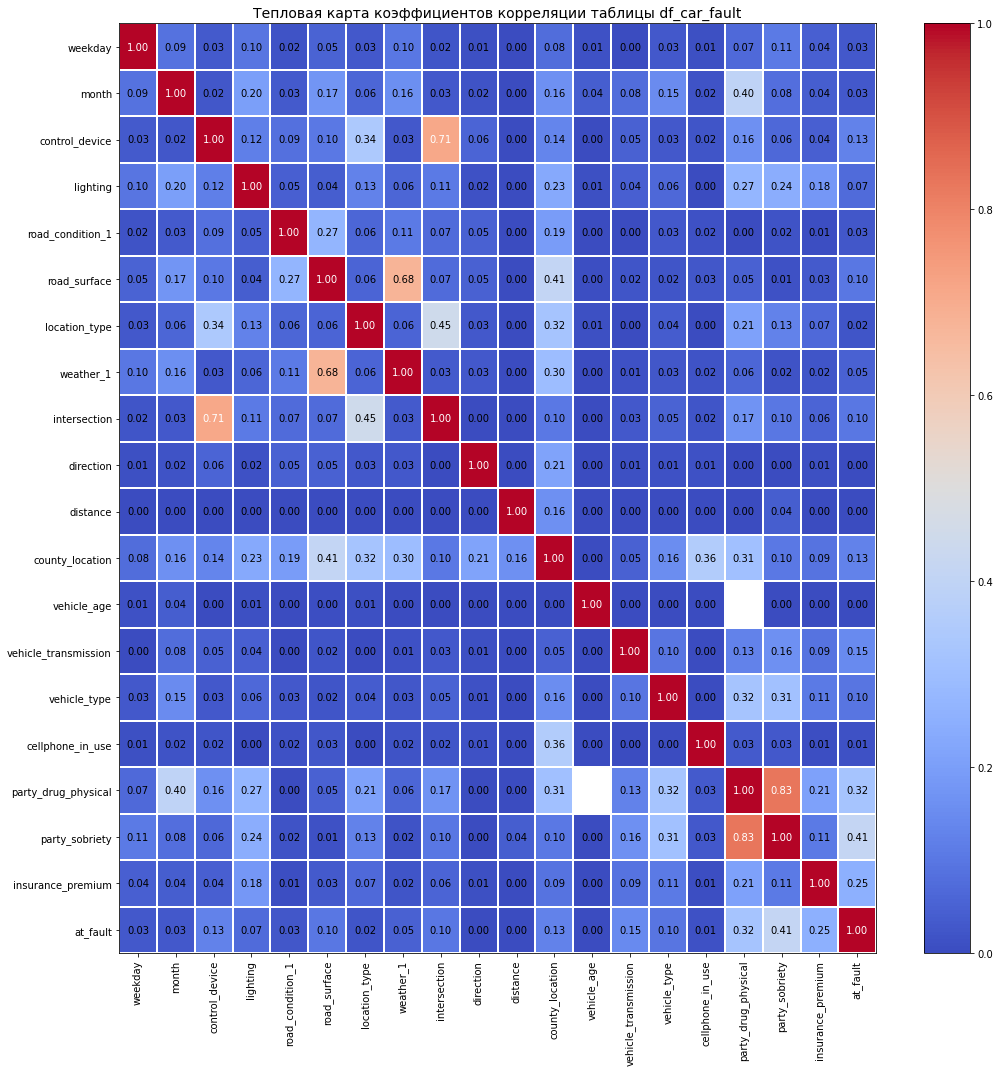

In [ ]:
phik_overview = df_car_fault[known_columns].phik_matrix(interval_cols=['insurance_premium', 'vehicle_age', 'distance',
                                                                       'month', 'weekday'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы df_car_fault",
                        fontsize_factor=1,
                        figsize=(15, 15))
plt.tight_layout()
plt.show()

Наблюдается значимая корреляция at_fault со следующими признаками:  
'insurance_premium',  
'party_sobriety',   
'party_drug_physical',  
'vehicle_type',  
'vehicle_transmission',  
'county_location',  
'intersection',  
'weather_1',  
'location_type',   
'road_surface',  
'road_condition_1',  
'lighting',  
'control_device',  
'month',  
'weekday'  
Их и будем использовать для построения модели.

Признак "vehicle_age" (возраст автомобиля) не коррелирует с целевым, на по требованию заказчика включен в данные для обучения модели.

### Подготовка данных для обучения

Сохраним данные отдельный датафрем:

In [ ]:
columns_train = [
 'at_fault',
'insurance_premium',
'party_sobriety',
'party_drug_physical',
'vehicle_type',
'vehicle_transmission',
'county_location',
'intersection',
'weather_1',
'location_type',
'road_surface',
'road_condition_1',
'lighting',
'control_device',
'month',
'weekday',
'vehicle_age'
]

In [ ]:
df_train = df_car_fault[columns_train]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   insurance_premium     55701 non-null  float64
 2   party_sobriety        55376 non-null  object 
 3   party_drug_physical   2857 non-null   object 
 4   vehicle_type          56248 non-null  object 
 5   vehicle_transmission  55389 non-null  object 
 6   county_location       56248 non-null  object 
 7   intersection          56073 non-null  float64
 8   weather_1             56080 non-null  object 
 9   location_type         25932 non-null  object 
 10  road_surface          55900 non-null  object 
 11  road_condition_1      55999 non-null  object 
 12  lighting              56094 non-null  object 
 13  control_device        56033 non-null  object 
 14  month                 56248 non-null  float64
 15  weekday            

In [ ]:
df_train.head()

,at_fault,insurance_premium,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,county_location,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,month,weekday,vehicle_age
0,0,54.0,had not been drinking,None,sedan,manual,contra costa,0.0,clear,None,dry,normal,dark with street lights,functioning,1.0,0.0,10.0
1,0,NaN,impairment unknown,G,sedan,auto,ventura,0.0,clear,highway,dry,normal,daylight,none,4.0,4.0,NaN
2,1,38.0,"had been drinking, under influence",None,sedan,auto,nevada,0.0,clear,None,dry,normal,dark with no street lights,none,4.0,6.0,6.0
3,1,20.0,had not been drinking,None,sedan,auto,kings,0.0,cloudy,highway,wet,normal,daylight,none,4.0,5.0,11.0
4,1,22.0,had not been drinking,None,sedan,manual,solano,0.0,cloudy,ramp,dry,normal,daylight,none,1.0,1.0,3.0


У нас есть пропуски в некоторых столбцах. Заполним их по возможности.

In [ ]:
df_train['insurance_premium'] = df_train['insurance_premium'].fillna(value=df_train['insurance_premium'].median())

In [ ]:
df_train['vehicle_age'] = df_train['vehicle_age'].fillna(value=df_train['vehicle_age'].median())

In [ ]:
df_train['party_sobriety'] = df_train['party_sobriety'].fillna('not applicable')

In [ ]:
df_train['party_drug_physical'] = df_train['party_drug_physical'].fillna('G')

In [ ]:
df_train['location_type'] = df_train['location_type'].fillna('not_state_highway')

In [ ]:
df_train['weather_1'] = df_train['weather_1'].fillna('other')

In [ ]:
df_train['road_condition_1'] = df_train['road_condition_1'].fillna('other')

In [ ]:
df_train['road_surface'] = df_train['road_surface'].fillna('unknown')

In [ ]:
df_train['lighting'] = df_train['lighting'].fillna('unknown')

В этих столбцах заполнить пропуски сколько-нибудь корректно не представляется возможным, лучше отбросить.

In [ ]:
df_train = df_train.loc[df_train['vehicle_transmission'].isna() == False]

In [ ]:
df_train = df_train.loc[df_train['intersection'].isna() == False]

In [ ]:
df_train['control_device'] = df_train['control_device'].fillna('none')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55217 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              55217 non-null  int64  
 1   insurance_premium     55217 non-null  float64
 2   party_sobriety        55217 non-null  object 
 3   party_drug_physical   55217 non-null  object 
 4   vehicle_type          55217 non-null  object 
 5   vehicle_transmission  55217 non-null  object 
 6   county_location       55217 non-null  object 
 7   intersection          55217 non-null  float64
 8   weather_1             55217 non-null  object 
 9   location_type         55217 non-null  object 
 10  road_surface          55217 non-null  object 
 11  road_condition_1      55217 non-null  object 
 12  lighting              55217 non-null  object 
 13  control_device        55217 non-null  object 
 14  month                 55217 non-null  float64
 15  weekday            

Все пропуски обработаны. Теперь проведем исследовательский анализ данных.

### Исследовательский анализ данных

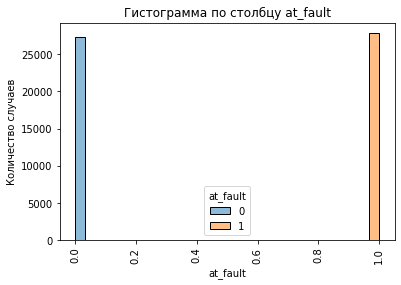

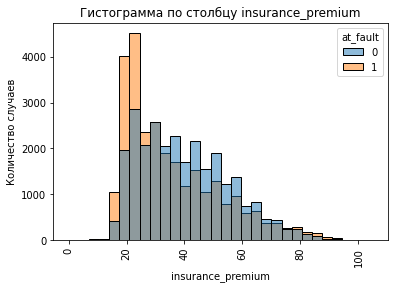

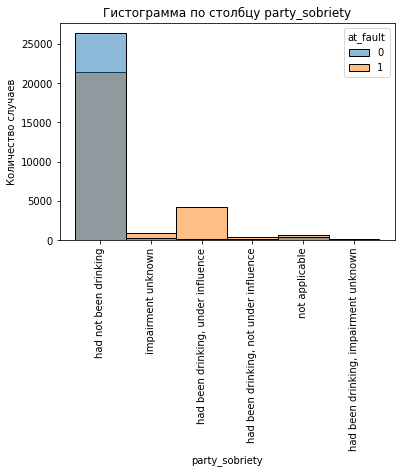

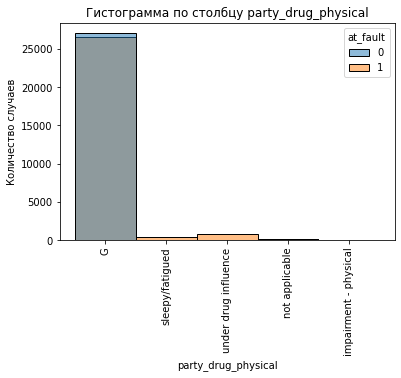

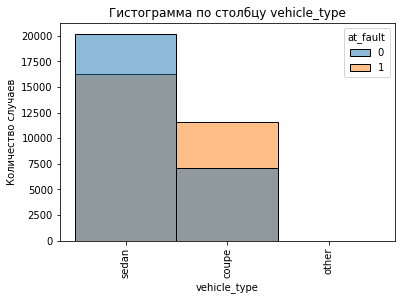

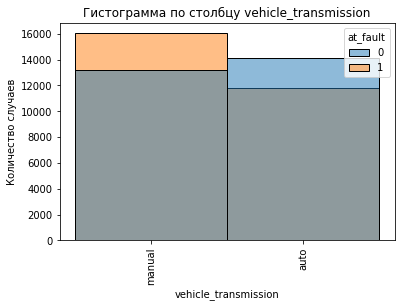

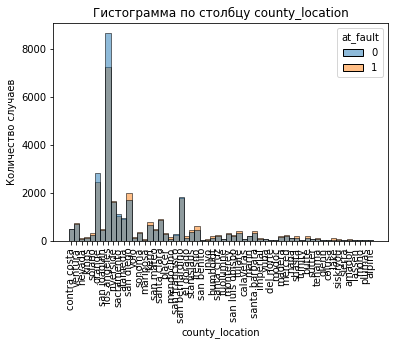

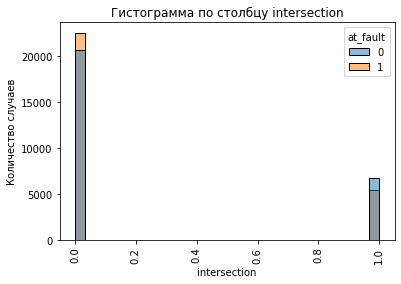

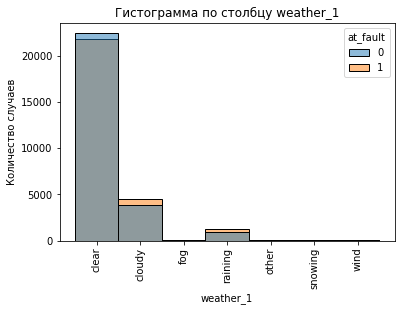

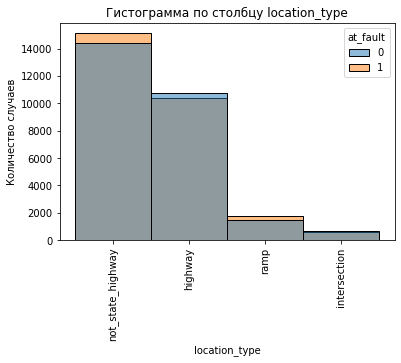

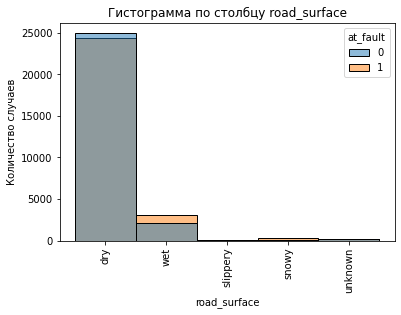

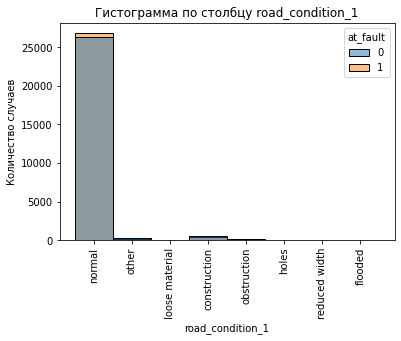

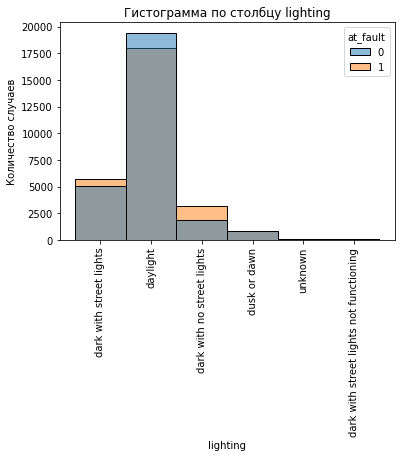

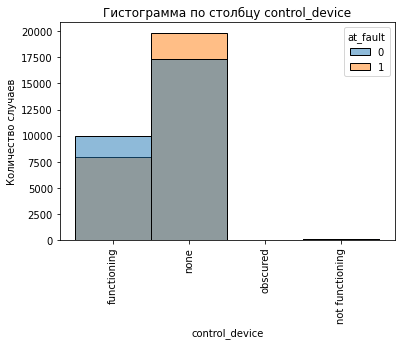

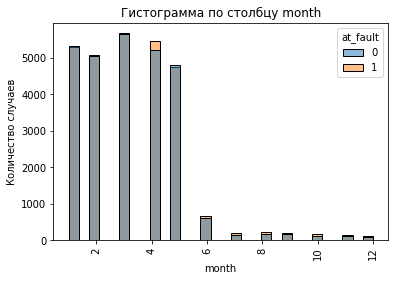

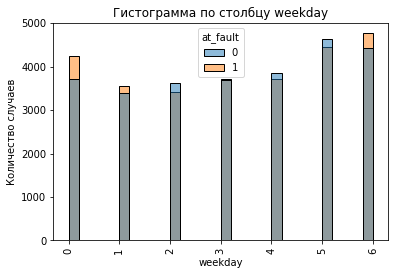

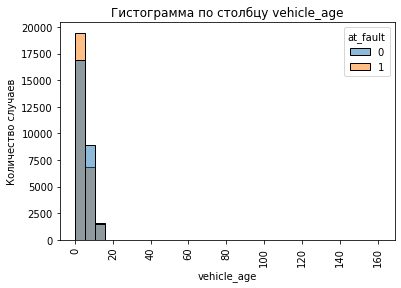

In [ ]:
for column in df_train.columns:
    ax=sns.histplot(df_train, x=column, hue='at_fault', bins = 30)
    ax.tick_params(axis='x', rotation=90)
    ax.set(xlabel=column, ylabel='Количество случаев', title=f'Гистограмма по столбцу {column}')
    plt.show()

Из диаграмм видно следующее:
1. Виновники аварий в среднем получают меньше страховые выплаты, чем те, кто виновником не является.
2. Доля аварий, совершенных в состоянии опьянения, небольшая, но почти во всех случах виноват тот, кто выпил.
3. В данных мало информации о людях под воздействием лекарств.
4. Наибольшее количество аварий случается в Лос-Анджелесе. При этом, количество невиновных в аварии там больше, чем виновных.
5. На перекрестках аварий случается меньше, чем вне их.
6. В ясную погоду совершается больше всего аварий.
7. Большинство аварий случаются не на перекрестках, не на рампе и не на шосса.
8. Большинство столкновений происходит на сухом асфальте, на нормальной дороге без повреждений и ясный день.
9. Чаще всего аварии случаются с седанами, реже - с минивенами.
10. Количество аварий машин с ручной или автоматической коробкой почти одинаковое, но с ручной всё же немного больше.
11. Чаще всего аварии случаются в воскресенье.
12. Среди машин встречаются экземпляры старше 150 лет. Это либо ошибка, либо раритетные машины. Лучше удалить такие выбросы из данных.

Удалим машины с очень большим возрастом.

In [ ]:
df_train = df_train.loc[df_train['vehicle_age'] < 30]

В некоторых столбцах очень много редких значений. Объединим их в одну категорию для упрощения построения модели.

В столбце county_location те города, в которых меньше 2000 случаев, перенесем в графу other.

In [ ]:
rare_location = ['fresno', 'san joaquin', 'stanislaus', 'santa barbara',
       'tulare', 'sonoma', 'placer', 'monterey', 'san francisco', 'solano',
       'santa cruz', 'san luis obispo', 'marin', 'merced', 'madera',
       'humboldt', 'yolo', 'butte', 'el dorado', 'kings', 'shasta', 'napa',
       'imperial', 'mendocino', 'nevada', 'sutter', 'tehama', 'tuolumne',
       'yuba', 'calaveras', 'lake', 'siskiyou', 'amador', 'san benito',
       'colusa', 'del norte', 'inyo', 'mariposa', 'lassen', 'mono', 'glenn',
       'trinity', 'plumas', 'alpine', 'modoc', 'sierra']

In [ ]:
df_train['county_location_freq'] = df_train['county_location'].replace(rare_location, 'other')

### Обучение моделей

Подготовим Pipeline для перебора гиперпараметров при обучении моделей и выбора лучшей из них. В качестве метрики будем использовать ROC-AUC, так как она не зависит от порога классификации и устойчива к несбалансированным классам.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(['at_fault', 'county_location'], axis=1),
    df_train['at_fault'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_train['at_fault'])

X_train.shape, X_test.shape

((41411, 16), (13804, 16))

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['party_sobriety',
               'party_drug_physical',
               'vehicle_type',
               'vehicle_transmission',
               'intersection',
               'weather_1',
               'location_type',
               'road_surface',
               'road_condition_1',
               'lighting',
               'control_device',
               'county_location_freq',
               'weekday',
               'month'
              ]
num_columns = ['insurance_premium', 'vehicle_age']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            penalty='l2'
        )],
        'models__solver':['liblinear',
                          'newton-cg',
                          'newton-cholesky'
                          'sag',
                          'saga'
                         ],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__num_leaves':[5],
        'models__max_depth':[5, 50],
        'models__learning_rate':[0.5],
        'models__n_estimators':[50],
        'models__subsample_for_bin':[10000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }


]


In [ ]:
%%time
# Ячейка выполняется около 20-30 минут.
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n',grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)

# проверка работы модели на тестовой выборке
pred = grid_search.predict_proba(X_test)
print(f'Метрика ROC_AUC на тестовой выборке: {roc_auc_score(y_test, pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['party_sobriety',
                                                   'party_drug_physical',
                                                   'vehicle_type',
                              

Сохраним лучшую модель и подготовку данных переменную:

In [ ]:
model = grid_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

**Итог:** наилучшая модель - LGBMClassifier.

### Оценка работы модели

Построим матрицу ошибок:

In [ ]:
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
y_pred = model.predict(X_test_preprocessed)

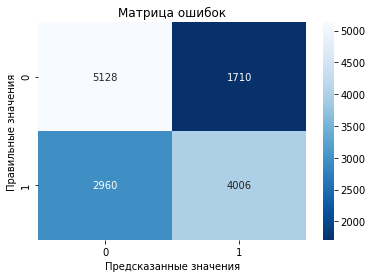

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Правильные значения')
plt.show()

Матрица ошибок построена. По ней видно, что большинство случаев модель определяет верно.

**Итог:** модели сформированы, обучены и выбрана лучшая из них.

## Анализ факторов

Анализ факторов, которые модель посчитала важными, проведем методом SHAP.

In [ ]:
shap_sample = shap.sample(X_test_preprocessed, 1)

In [ ]:
# Ячейка выполняется около часа.
explainer = shap.KernelExplainer(model.predict, shap_sample)
shap_values = explainer(X_test_preprocessed)

  0%|          | 0/13804 [00:00<?, ?it/s]

Сформируем названия признаков:

In [ ]:
encoder = ohe_pipe['ohe']
# обучение кодирования на тренировочных данных
encoder.fit(X_train[ohe_columns].dropna())

cat_encoder = encoder.get_feature_names_out()

num_features = ['insurance_premium', 'weekday', 'month', 'party_count']

feature_names = np.concatenate([cat_encoder, num_features])

Построим график:

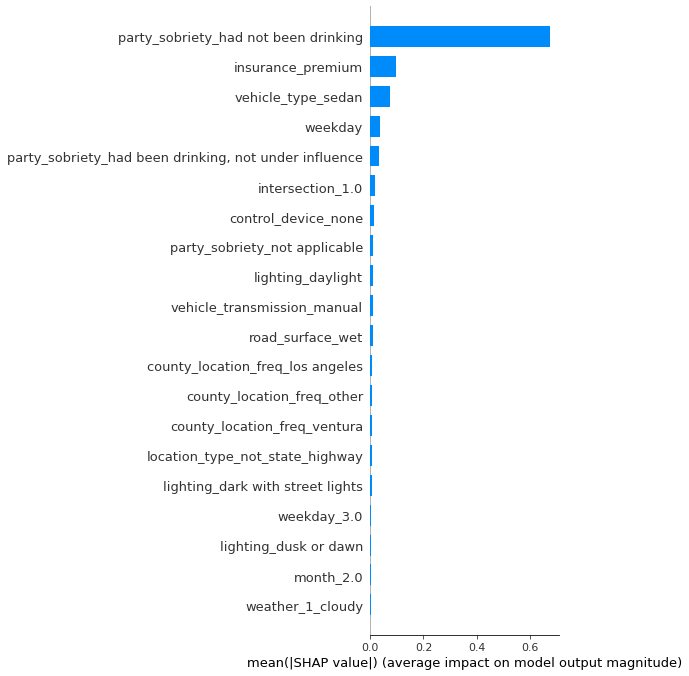

In [ ]:
shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar", feature_names=feature_names)

Наибольшее влияние оказывает то, что водитель не пил перед поездкой, второй по значимости признак - сумма страхования, третий - автомобиль типа седан.

Построим график повторно для трёх наиболее важных факторов.

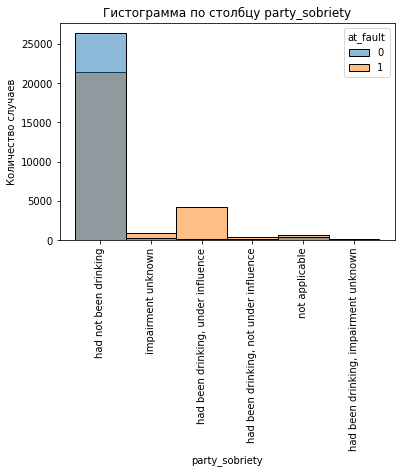

In [ ]:
ax=sns.histplot(df_train, x='party_sobriety', hue='at_fault', bins = 30)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='party_sobriety', ylabel='Количество случаев', title=f'Гистограмма по столбцу party_sobriety')
plt.show()

Как видно из диаграммы, водитель, который перед поездкой не употреблял алкоголь, чаще всего оказывался невиновным в ДТП.

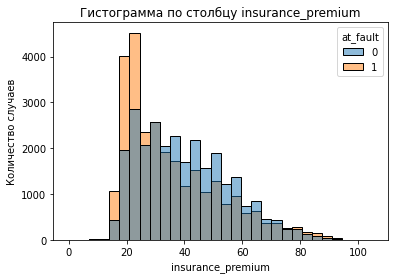

In [ ]:
ax=sns.histplot(df_train, x='insurance_premium', hue='at_fault', bins = 30)
ax.set(xlabel='insurance_premium', ylabel='Количество случаев', title=f'Гистограмма по столбцу insurance_premium')
plt.show()

Как видно из диаграммы, наибольшее количество виновных в ДТП приходиться на машине, для которых сумма страхования небольшая (до 30 тыс. долларов). Скорее всего люди на более дорогих машинах менее склоны к риску до определенного момента. При сумме страхования более 80 тыс. долларов количество виновных опять выше числа невиновных. Скорее всего, это связано с тем, что на дорогих машинах люди склоны "лихачить".

In [ ]:
ax=sns.histplot(df_train, x='vehicle_type', hue='at_fault', bins = 30)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='vehicle_type', ylabel='Количество случаев', title=f'Гистограмма по столбцу vehicle_type')
plt.show()

По диаграмме видно, что наибольшее количество аварий с автомобилями типа седан. Скорее всего, это связано с тем, что седан наиболее популярный тип автомобилей.

**Предложения:**
1. При посадке в автомобиль указывать на видном месте справочную информацию о стоимости ремонта той или иной детали, к примеру, бампера.
2. Ужесточить правила сдачи самых дорогих автомобилей. К примеру, предоставлять такую возможность только тем, кто имеет высокую статистику безаварийного вождения.
3. Установить в автомобиль алкотестер и давать возможность поехать только после проведения проверки.

**Итог:** модель проанализированы, наиболее значимые факторы определены.

## Выводы
В рамках работы сделано:
1. Проведен исследовательский и корреляционный анализ данных.
2. Сформированы и обучены 4 модели.
3. Выбрана лучшая модель.
4. Определены факторы, наиболее влияющие на принятие решения.
5. Предложены пути снижения вероятности ДТП.

Результаты работы:
1. Наилучшая модель среди обученных - LGBMClassifier на основе градиентного бустинга. Метрика ROC-AUC на тестовой выборке составила 0,72.
2. Фактор, оказавший наибольшее влияние на решение модели - пил или нет человек алкоголь перед началом движения. Если он не пил, то чаще всего оказывался невиновным.

Рекомендации для улучшения прогноза:
1. Для улучшения прогноза желательно иметь больше информации о водителях, а именно возраст, стаж вождения, статистику по авариям.
2. Желательно также больше информации об автомобилях: марку, модель, пробег, информацию о последнем ТО и замене шин.

**Общая резолюция:**
по предоставленным данным трудно надежно спрогнозировать вероятность ДТП.